# PyDelfi

This module gets cosmological constraints from simulations of the CMB Cls using pydelfi. This serves to get an estimate of the sampling error, that we can then compare to MultiSWAG's

In [1]:
import numpy as np
import matplotlib.pyplot as plt
#import priors as priors
import pydelfi.ndes as ndes
import pydelfi.delfi as delfi
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
import getdist.plots
#tf.logging.set_verbosity(tf.logging.ERROR)
%matplotlib inline

from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LeakyReLU

import sys
sys.path.append("../cosmoswag") 
from cmb_simulator import *
from data_object import read_data
from swag import SWAGModel
import torch

/Users/pl332/miniforge3/envs/tf/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/Users/pl332/miniforge3/envs/tf/lib/python3.8/site-packages/pydelfi-0.2-py3.8.egg/pydelfi/delfi.py:91: SyntaxWarning: "is" with a literal. Did you mean "=="?
/Users/pl332/miniforge3/envs/tf/lib/python3.8/site-packages/pydelfi-0.2-py3.8.egg/pydelfi/delfi.py:96: SyntaxWarning: "is" with a literal. Did you mean "=="?
/Users/pl332/miniforge3/envs/tf/lib/python3.8/site-packages/pydelfi-0.2-py3.8.egg/pydelfi/delfi.py:554: SyntaxWarning: "is" with a literal. Did you mean "=="?
/Users/pl332/miniforge3/envs/tf/lib/python3.8/site-packages/pydelfi-0.2-py3.8.egg/pydelfi/delfi.py:91: SyntaxWarning: "is" with a literal. Did you mean "=="?
/Users/pl332/miniforge3/envs/tf/lib/python3.8/site-packages/pydelfi-0.2-py3.8.egg/pydelfi/delfi.py:96: SyntaxWarning: "is" with a literal. Did you mean "==

In [2]:
tf.config.list_physical_devices('CPU')
tf.config.run_functions_eagerly(False)

#### Read the CL simulations

In [3]:
data = read_data()
data.read_truth(filename="simulated_truth.txt")
x_train, y_train, x_val, y_val = data.get_data()
delta_x = data.get_error()
truth = data.get_truth()

In [4]:
nin = x_val.shape[1]
npars = y_val.shape[1]
model = SWAGModel(nin=nin, npars = npars)
model.load("cmb_min.pt")

In [5]:
for i in range(len(x_train)): 
    x_train[i] = x_train[i] + torch.normal(0, delta_x)
sim_compressed_data = model(x_train).detach().numpy()
sim_params = y_train.detach().numpy()
compressed_data = model(truth + torch.normal(0, delta_x)).detach().numpy()

In [6]:
NDEs = [ndes.ConditionalMaskedAutoregressiveFlow(
            n_parameters=5,
            n_data=5,
            n_mades=5,
            n_hidden=[30,30], 
            activation=tf.keras.layers.LeakyReLU(0.01),
            kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=1e-5, seed=None),
            all_layers=True)]

# NDEs += [ndes.MixtureDensityNetwork(
#             n_parameters=5,
#             n_data=5, 
#             n_components=6,
#             n_hidden=[30, 30], 
#             activation=tf.keras.layers.LeakyReLU(0.01))
#         ]

In [7]:
lower = np.zeros(5)
upper = np.ones(5)
prior = tfd.Blockwise([tfd.Uniform(low=lower[i], high=upper[i]) for i in range(5)])

In [8]:
theta_fiducial = 0.5*np.ones(5)

DelfiEnsemble = delfi.Delfi(compressed_data[0], prior, NDEs, 
                            Finv=np.identity(5), 
                            theta_fiducial=theta_fiducial,
                            param_limits = [lower, upper],
                            param_names=["H_0", "\Omega_\mathrm{b} h^2", "\Omega_\mathrm{c} h^2", "\log A", "n_s"], 
                            results_dir="/Users/pl332/Desktop/pydelfi_results/",
                            filename="cosmic_shear",
                            optimiser=tf.keras.optimizers.Adam(lr=1e-4),
                            optimiser_arguments=None,
                            dtype=tf.float32,
                            posterior_chain_length=200,
                            nwalkers=500,
                            input_normalization=None)

/Users/pl332/miniforge3/envs/tf/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [9]:
DelfiEnsemble.load_simulations(sim_compressed_data, sim_params)

In [10]:
#DelfiEnsemble.fisher_pretraining(n_batch=5000, epochs=1000, patience=20, plot=False)

In [11]:
DelfiEnsemble.train(f_val=0.1, epochs=10000, n_batch=256, patience=20)

2022-02-25 11:41:47.770779: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


Training:   0%|          | 0/10000 [00:00<?, ?it/s]

2022-02-25 11:41:49.362754: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Training terminated for model 0 at epoch 680.


In [12]:
posterior_samples, posterior_weights = DelfiEnsemble.affine_sample()

Sampling:   0%|          | 0/1100 [00:00<?, ?it/s]

In [17]:
unnormed_samples = data.unnormalize_params(torch.tensor(posterior_samples)).detach().numpy()
lower = data.paramMins.detach().numpy()
upper = data.paramMaxs.detach().numpy()
DelfiEnsemble.lower = None
DelfiEnsemble.upper = None

Removed no burn in


MCSamplesError: Parameter range is <= 0: H_0

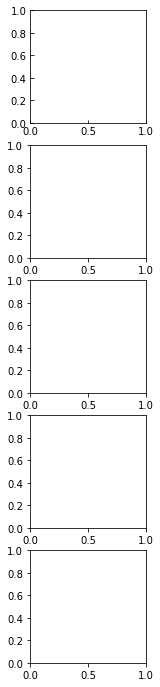

In [18]:
DelfiEnsemble.triangle_plot(samples=[unnormed_samples], weights=[posterior_weights])

In [23]:
from getdist import loadMCSamples, MCSamples, plots
import getdist

In [30]:
names = ["H0", "ombh2",  "omch2", "logA", "ns"]
labels =  ["H_0", "\Omega_\mathrm{b} h^2", "\Omega_\mathrm{c} h^2", "\log A", "n_s"]
samples = MCSamples(samples=unnormed_samples,names = names, labels = labels, weights=posterior_weights, 
                   ranges={'H0':(62, 74), 
                           'ombh2':(0.02, 0.024),
                           'omch2':(0.105, 0.14),
                           'logA':(2.95, 3.15),
                           'ns':(0.93, 1)
                          })

Removed no burn in


In [31]:
trueSamples = loadMCSamples("../cobaya/chains/sim")

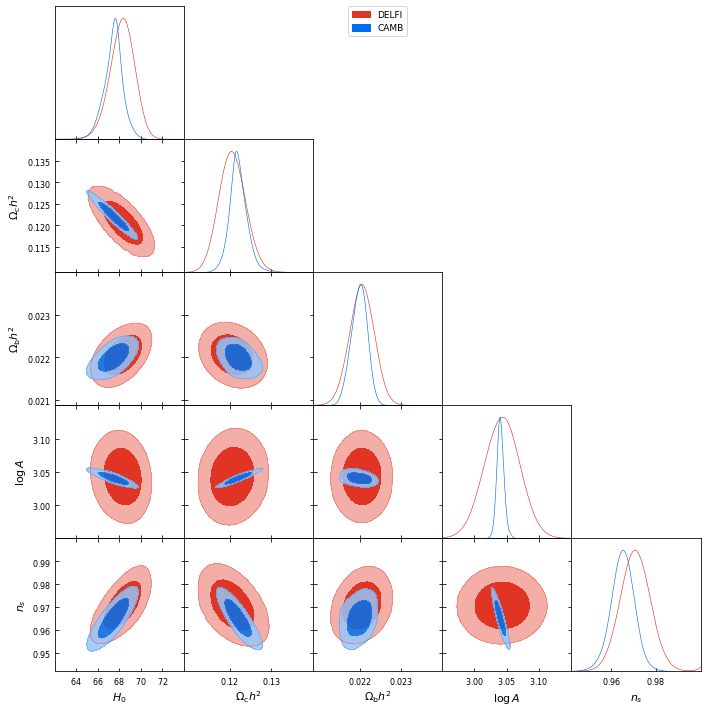

In [32]:
g = getdist.plots.getSubplotPlotter()
g.triangle_plot([samples, trueSamples],["H0", "omch2",  "ombh2", "logA", "ns"], 
                filled=True,
                legend_labels = ['DELFI', 'CAMB']
               )